In [1]:
from pathlib import Path
from patchify import patchify
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# Define the directory containing the dataset
directory = Path('dataset')
scaler = MinMaxScaler()
patch_size = 256
image_dataset = []

# Walk through the directory to find images
for path in directory.glob('**/images'):
    images = sorted(path.glob('*.jpg'))  
    print(f'Found images in: {path.name}')
    print([img.name for img in images])
    
    for image_path in images:
        image = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
        
        if image is None:
            print(f'Error loading image: {image_path}')
            continue  # Skip if image is not loaded properly
        
        # Resize the image to be divisible by the patch size
        x_size = (image.shape[1] // patch_size) * patch_size
        y_size = (image.shape[0] // patch_size) * patch_size
        image = Image.fromarray(image).crop((0, 0, x_size, y_size))
        image = np.array(image)

        # Extract patches from each image with overlap
        patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

        # Normalize each patch and append to dataset
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_img = patches_img[i, j, :, :]
                single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                
                single_patch_img = single_patch_img[0]
                image_dataset.append(single_patch_img)

Found images in: images
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
Found images in: images
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
Found images in: images
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
Found images in: images
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']


In [3]:
# Define the patch size and initialize the mask dataset
patch_size = 256
mask_dataset = []

# Walk through the directory to find masks
for path in directory.glob('**/masks'):
    masks = sorted(path.glob('*.png'))  # List all png masks in sorted order
    print(f'Found masks in: {path.name}')
    print([mask.name for mask in masks])

    for mask_path in masks:
        mask = cv2.imread(str(mask_path), cv2.IMREAD_COLOR)

        if mask is None:
            print(f'Error loading mask: {mask_path}')
            continue  # Skip if the mask is not loaded properly

        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        x_size = (mask.shape[1] // patch_size) * patch_size
        y_size = (mask.shape[0] // patch_size) * patch_size
        mask = Image.fromarray(mask).crop((0, 0, x_size, y_size))
        mask = np.array(mask)

        # Extract patches from each mask with overlap
        patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

        # Append each single patch to the mask dataset
        for row in range(patches_mask.shape[0]):
            for col in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[row, col, :, :]

                single_patch_mask = single_patch_mask[0]
                mask_dataset.append(single_patch_mask)

Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png']
Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png']
Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png']
Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png']


In [4]:
#converting the image and masks lists into arrays
image_dataset = np.array(image_dataset)
image_dataset = scaler.fit_transform(image_dataset.reshape(-1, 1)).reshape(image_dataset.shape)

mask_dataset = np.array(mask_dataset)

print(image_dataset.shape, mask_dataset.shape)

(216, 256, 256, 3) (216, 256, 256, 3)


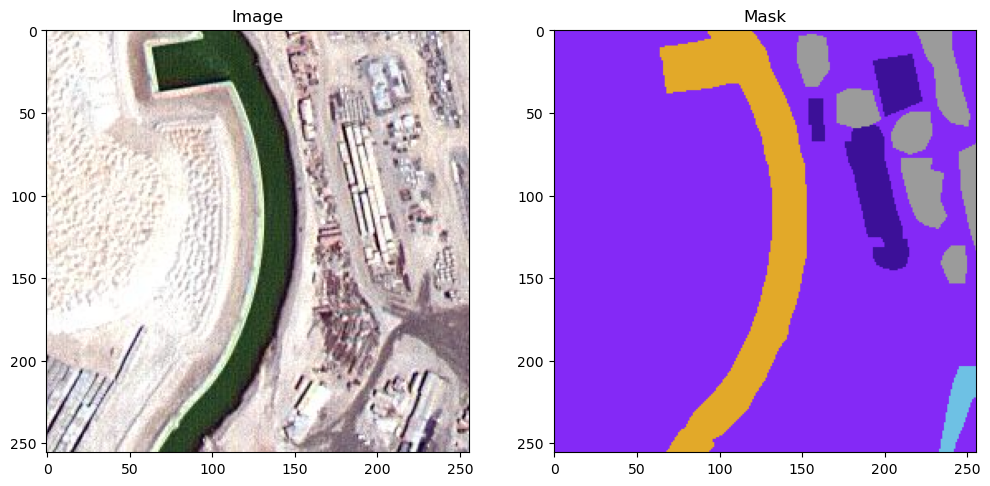

In [5]:
# Check the consistency between the images and masks 
check_number = np.random.randint(0, len(image_dataset))

# Create a figure to display the selected image and its corresponding mask
fig = plt.figure(figsize=(12, 10))
ax = fig.subplot_mosaic("""AB""")
ax['A'].imshow(image_dataset[0])
ax['A'].set_title('Image')
ax['B'].imshow(mask_dataset[0])
ax['B'].set_title('Mask')
plt.show()

In [6]:
# Define hexadecimal colors for each class
class_colors_hex = {
    'Building': '#3C1098',
    'Land': '#8429F6',
    'Road': '#6EC1E4',
    'Vegetation': '#FEDD3A',
    'Water': '#E2A929',
    'Unlabeled': '#9B9B9B'
}

# Function to convert hexadecimal colors to RGB integer values
def hex_to_int(hex_color):
    hex_color = hex_color.lstrip('#')  # Remove the '#' from the beginning
    return np.array(tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4)))  # Convert to RGB

# Create a dictionary mapping class names to their RGB integer values
class_colors = {key: hex_to_int(value) for key, value in class_colors_hex.items()}

print(class_colors)

{'Building': array([ 60,  16, 152]), 'Land': array([132,  41, 246]), 'Road': array([110, 193, 228]), 'Vegetation': array([254, 221,  58]), 'Water': array([226, 169,  41]), 'Unlabeled': array([155, 155, 155])}


In [7]:
# Function to convert RGB colors in the label masks to integer labels
def rgb_to_2D_label(label):
    """
    Convert RGB mask to integer labels based on predefined class colors.

    Args:
        label (np.ndarray): Input mask in RGB format.

    Returns:
        np.ndarray: Segmentation mask with integer labels.
    """
    # Initialize a label mask with zeros
    label_seg = np.zeros(label.shape[:-1], dtype=np.uint8)
    
    # Assign integer labels based on RGB values
    for idx, color in enumerate(class_colors.values()):
        label_seg[np.all(label == color, axis=-1)] = idx  # Match the color

    return label_seg

# Convert all masks in mask_dataset to integer labels
labels = np.array([rgb_to_2D_label(mask) for mask in mask_dataset])  
labels = np.expand_dims(labels, axis=3)  # Add an extra dimension

print("Unique labels in label dataset are: ", np.unique(labels))
print("Shape of the labels is: ", labels.shape)

Unique labels in label dataset are:  [0 1 2 3 4 5]
Shape of the labels is:  (216, 256, 256, 1)


In [8]:
from tensorflow.keras.utils import to_categorical
num_classes = len(class_colors)
labels_categ = to_categorical(labels, num_classes=num_classes)  
print("Shape of one-hot encoded labels:", labels_categ.shape)

Shape of one-hot encoded labels: (216, 256, 256, 6)


In [9]:
# Splitting the data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_categ, test_size=0.20, random_state=42)

# Further splitting the test data into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Outputting the shapes of each split
print(f'Shape of training data: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Shape of validation data: X_val: {X_val.shape}, y_val: {y_val.shape}')
print(f'Shape of test data: X_test: {X_test.shape}, y_test: {y_test.shape}')

Shape of training data: X_train: (172, 256, 256, 3), y_train: (172, 256, 256, 6)
Shape of validation data: X_val: (22, 256, 256, 3), y_val: (22, 256, 256, 6)
Shape of test data: X_test: (22, 256, 256, 3), y_test: (22, 256, 256, 6)


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation Configuration
data_gen_args = dict(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Create ImageDataGenerator for images and masks
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Set seed for reproducibility
seed = 42

# Generate training batches
def create_generator(image_generator, mask_generator, X, y, batch_size, seed):
    """
    Creates a generator for images and masks with consistent augmentation.
    
    Parameters:
    - image_generator: ImageDataGenerator for images.
    - mask_generator: ImageDataGenerator for masks.
    - X: Input images.
    - y: Masks.
    - batch_size: Batch size.
    - seed: Random seed for reproducibility.
    
    Returns:
    - A generator yielding tuples of (images, masks).
    """
    image_generator = image_generator.flow(X, batch_size=batch_size, seed=seed)
    mask_generator = mask_generator.flow(y, batch_size=batch_size, seed=seed)
    
    while True:
        X_batch = next(image_generator)
        y_batch = next(mask_generator)
        yield X_batch, y_batch

# Create training generator
train_generator = create_generator(image_datagen, mask_datagen, X_train, y_train, batch_size=32, seed=seed)

# Create validation generator (no augmentation)
val_datagen = ImageDataGenerator()
val_generator = create_generator(val_datagen, val_datagen, X_val, y_val, batch_size=32, seed=seed)

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Conv2DTranspose, concatenate, Multiply, Add, GlobalAveragePooling2D, Reshape, Activation
from tensorflow.keras.models import Model

def attention_gate(F_g, F_l, inter_channels):
    """
    Attention Gate mechanism as proposed in 'Attention U-Net: Learning Where to Look for the Pancreas'.
    
    Parameters:
    - F_g: Gating signal from the decoder.
    - F_l: Feature map from the encoder.
    - inter_channels: Intermediate number of channels.
    
    Returns:
    - Attention-weighted feature map.
    """
    # Transform gating signal
    W_g = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal')(F_g)
    W_g = BatchNormalization()(W_g)

    # Transform feature map
    W_x = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal')(F_l)
    W_x = BatchNormalization()(W_x)

    # Combine and apply ReLU
    psi = ReLU()(Add()([W_g, W_x]))

    # Apply convolution and sigmoid activation
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal')(psi)
    psi = Activation('sigmoid')(psi)

    # Multiply attention map with the input feature map
    return Multiply()([F_l, psi])


def unet(n_classes=6, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
    """
    Builds an improved U-Net model with attention gates and skip connections.
    
    Parameters:
    - n_classes (int): Number of output classes.
    - IMG_HEIGHT (int): Height of the input image.
    - IMG_WIDTH (int): Width of the input image.
    - IMG_CHANNELS (int): Number of channels in the input image.
    
    Returns:
    - model (keras.Model): Compiled U-Net model.
    """
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Encoder Path
    c0 = Conv2D(16, (3, 3), padding='same', kernel_initializer='he_normal')(inputs)
    c0 = BatchNormalization()(c0)
    c0 = ReLU()(c0)
    p0 = MaxPooling2D((2, 2))(c0)

    c1 = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(p0)
    c1 = BatchNormalization()(c1)
    c1 = ReLU()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(p1)
    c2 = BatchNormalization()(c2)
    c2 = ReLU()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(p2)
    c3 = BatchNormalization()(c3)
    c3 = ReLU()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(p3)
    c4 = BatchNormalization()(c4)
    c4 = ReLU()(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(p4)
    c5 = BatchNormalization()(c5)
    c5 = ReLU()(c5)

    # Decoder Path with Attention Gates
    u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    att6 = attention_gate(u6, c4, inter_channels=128)
    u6 = concatenate([u6, att6])
    c6 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(u6)
    c6 = BatchNormalization()(c6)
    c6 = ReLU()(c6)

    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    att7 = attention_gate(u7, c3, inter_channels=64)
    u7 = concatenate([u7, att7])
    c7 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(u7)
    c7 = BatchNormalization()(c7)
    c7 = ReLU()(c7)

    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    att8 = attention_gate(u8, c2, inter_channels=32)
    u8 = concatenate([u8, att8])
    c8 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(u8)
    c8 = BatchNormalization()(c8)
    c8 = ReLU()(c8)

    u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    att9 = attention_gate(u9, c1, inter_channels=16)
    u9 = concatenate([u9, att9])
    c9 = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(u9)
    c9 = BatchNormalization()(c9)
    c9 = ReLU()(c9)

    u10 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c9)
    att10 = attention_gate(u10, c0, inter_channels=8)
    u10 = concatenate([u10, att10])
    c10 = Conv2D(16, (3, 3), padding='same', kernel_initializer='he_normal')(u10)
    c10 = BatchNormalization()(c10)
    c10 = ReLU()(c10)

    # Output Layer
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c10)

    # Compile Model
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [12]:
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU


def iou(y_true, y_pred):
    """
    Intersection over Union (IoU) metric.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Threshold predictions to binary mask

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)  # Add small epsilon to avoid division by zero
    return iou


def dice_coefficient(y_true, y_pred):
    """
    Dice Coefficient metric.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Threshold predictions to binary mask

    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2.0 * intersection + 1e-7) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-7)
    return dice


def per_class_accuracy(y_true, y_pred):
    """
    Per-class accuracy metric.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Threshold predictions to binary mask

    class_accuracies = []
    for class_id in range(y_true.shape[-1]):  # Iterate over each class
        true_class = y_true[..., class_id]
        pred_class = y_pred[..., class_id]
        correct_pixels = tf.reduce_sum(tf.cast(tf.equal(true_class, pred_class), tf.float32))
        total_pixels = tf.reduce_sum(tf.ones_like(true_class))
        class_accuracy = correct_pixels / total_pixels
        class_accuracies.append(class_accuracy)
    return tf.reduce_mean(class_accuracies)



# Assuming you have 6 classes
num_classes = 6
mean_iou = MeanIoU(num_classes=num_classes)

In [13]:
# Compile the model
model = unet()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', iou, dice_coefficient, per_class_accuracy, mean_iou]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ re_lu_3[0][0]   

 Total params: 3,939,603 (15.03 MB)

 Trainable params: 3,935,603 (15.01 MB)

 Non-trainable params: 4,000 (15.62 KB)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_iou',  # Monitor IoU on the validation set
    patience=10,         # Number of epochs with no improvement after which training will stop
    restore_best_weights=True,  # Restores the weights from the epoch with the best validation IoU
    mode='max'           # Specify that we want to maximize IoU
)

# Train the model with early stopping
history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(X_train) // 32,
    validation_steps=len(X_val) // 32,
    epochs=5,
    callbacks=[early_stopping]
)

d:\Masrafe\Coding\python\anaconda\Lib\site-packages\keras\src\legacy\preprocessing\image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (172, 256, 256, 6) (6 channels).
  warnings.warn(


Epoch 1/5


d:\Masrafe\Coding\python\anaconda\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2594 - dice_coefficient: 0.0242 - iou: 0.0124 - loss: 1.7906 - mean_io_u: 0.4202 - per_class_accuracy: 0.8198

d:\Masrafe\Coding\python\anaconda\Lib\site-packages\keras\src\legacy\preprocessing\image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (22, 256, 256, 6) (6 channels).
  warnings.warn(


KeyboardInterrupt: 